In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os

In [2]:
data_dir = 'data/akimenko/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/akimenko/'
os.system('mkdir -p {}'.format(plot_dir))

save_plot = True

In [ ]:
momentum = 7.3e3 # GeV/c , 
m = 105.7 # MeV
E = np.round(np.sqrt(momentum**2 + m**2))
print('energy E = {} MeV'.format(E) )


E_i = E # momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = 31125 # total measured events in akimenko
    
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-3 # 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 71530

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 1.44 # in cm

In [ ]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Copper(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


# collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
# '''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
# '''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

# Run simulation

In [ ]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

In [ ]:
tracks_144 = []
for track in tracks:
    if track.track_propagated_distances()[-1] == max_dist:
        tracks_144.append(track)

In [ ]:
tracks_144_zenith = []
tracks_144_azimuth = []
tracks_144_x = []
tracks_144_y = []
tracks_144_z = []
tracks_144_pos_x = []
tracks_144_pos_y = []
tracks_144_pos_z = []
for track in tqdm(tracks_144):
    tracks_144_zenith.append(track.track_directions()[-1].spherical_coordinates[2])
    tracks_144_azimuth.append(track.track_directions()[-1].spherical_coordinates[1])
    tracks_144_x.append(track.track_directions()[-1].x)
    tracks_144_y.append(track.track_directions()[-1].y)
    tracks_144_z.append(track.track_directions()[-1].z)
    tracks_144_pos_x.append(track.track_positions()[-1].x)
    tracks_144_pos_y.append(track.track_positions()[-1].y)
    tracks_144_pos_z.append(track.track_positions()[-1].z)

In [ ]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_144_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_144_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

In [ ]:
bins = (np.linspace(-0.1, 0.1, 50), np.linspace(-0.1, 0.1, 50))
n = plt.hist2d(tracks_144_x, tracks_144_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)
plt.colorbar()
np.max(n[0])

## save data

In [ ]:
# '''
df = pd.DataFrame()
df['tracks_144_x'] = tracks_144_x
df['tracks_144_y'] = tracks_144_y
df['tracks_144_z'] = tracks_144_z
df['tracks_144_pos_x'] = tracks_144_pos_x
df['tracks_144_pos_y'] = tracks_144_pos_y
df['tracks_144_pos_z'] = tracks_144_pos_z
df['tracks_144_zenith'] = tracks_144_zenith
df['tracks_144_azimuth'] = tracks_144_azimuth
key = 'E{}_{}_v_cut{}'.format(int(E_i), scattering_method, v_cut)
df.to_hdf(data_dir + 'sim_data.hdf5', key=key)
print(key)
# '''

## read data

In [ ]:
key_0 = 'E7301_moliere_v_cut0.001'
df_0 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_0)
df_0.to_hdf(data_dir + 'sim_data.hdf5', key=key_0)

# key_2 = 'E199_highland_v_cut0.001'
# df_2 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_2)
# df_2.to_hdf(data_dir + 'sim_data.hdf5', key=key_2)

key_5 = 'E7301_moliere_v_cut1e-05'
df_5 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_5)
df_5.to_hdf(data_dir + 'sim_data.hdf5', key=key_5)

# key_6 = 'E199_moliere_v_cut1e-05_G4defl'
# df_6 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_6) # not relevant because there are only ionizations -> hence the
# deflection parametrization for brems and nuclint does not effect anything

key_7 = 'E7301_only_moliere_v_cut1e-05'
df_7 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_7)

# Plot all 

In [ ]:
# binning = [Akimenko.angle[i] - abs(Akimenko.angle[i+1] - Akimenko.angle[i])/2 for i in range(len(Akimenko)-1)]
# binning.append(Akimenko.angle.values[-1] - abs(Akimenko.angle.values[-1] - Akimenko.angle.values[-2])/2)
# binning.append(Akimenko.angle.values[-1] + abs(Akimenko.angle.values[-1] - Akimenko.angle.values[-2])/2)
# binning

In [ ]:
binning = [Akimenko.angle[0] - abs(Akimenko.angle[1] - Akimenko.angle[0])/2]
binning_h = [Akimenko.angle[i] + abs(Akimenko.angle[i+1] - Akimenko.angle[i])/2 for i in range(len(Akimenko)-1)]
for b in binning_h:
    binning.append(b)
binning.append(Akimenko.angle.values[-1] + abs(Akimenko.angle.values[-1] - Akimenko.angle.values[-2])/2 )
binning

In [ ]:
# plot y direction

plt.plot(Akimenko.angle, Akimenko.probability, 'o', color='black', alpha=0.7, label='Akimenko')

bins = binning
plt.hist(df_0.tracks_144_y, bins=bins, histtype='step', label='PROPOSAL v = 1e-3')
plt.hist(df_5.tracks_144_y, bins=bins, histtype='step', label='PROPOSAL v = 1e-5')
plt.hist(df_7.tracks_144_y, bins=bins, histtype='step', label='PROPOSAL v = 1e-5 M.') # only Molière 



plt.ylabel('counts')
# plt.xlabel('y angle in rad')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$rad')
plt.yscale('log')
plt.legend(loc='upper right', fontsize='small')
print('moliere, E = {} MeV'.format(E))
plt.savefig(plot_dir + 'akimenko_comparison_moliere_E7301MeV_final.pdf', bbox_inches='tight')

In [ ]:
x Achse beachten! was ist mit total scattering angle theta in dunsch gemeint???

# Akimenko multiprocessing

In [12]:
AKIMENKO = pd.read_csv('data/akimenko/Akimenko_true_data.txt', sep='\s+', names=['angle_low', 'angle_high', 'counts'], skiprows=1)

In [71]:
df_01 = pd.read_hdf('data/akimenko_7301MeV_copper/akimenko_run_01.hdf5') # v_cut = 1e-5
df_02 = pd.read_hdf('data/akimenko_7301MeV_copper/akimenko_run_02.hdf5') # v_cut = 1e-5 only Moliere
df_03 = pd.read_hdf('data/akimenko_7301MeV_copper/akimenko_run_03.hdf5') # v_cut = 1e-3
df_04 = pd.read_hdf('data/akimenko_7301MeV_copper/akimenko_run_04.hdf5') # v_cut = 1e-3 only Moliere
df_05 = pd.read_hdf('data/akimenko_7301MeV_copper/akimenko_run_04.hdf5') # v_cut = 0.05, e_cut = 500 MeV

# distance should be 1.44 cm
print(np.unique(df_01.distances))
print(np.unique(df_02.distances))
print(np.unique(df_03.distances))
print(np.unique(df_04.distances))
print(np.unique(df_05.distances))

df_01 = df_01[df_01.distances == 0.0144]
df_02 = df_02[df_02.distances == 0.0144]
df_03 = df_03[df_03.distances == 0.0144]
df_04 = df_04[df_04.distances == 0.0144]
df_05 = df_05[df_05.distances == 0.0144]

[0.0144]
[0.00817724 0.0144    ]
[0.00256256 0.0144    ]
[0.00463499 0.00928377 0.0144    ]
[0.00463499 0.00928377 0.0144    ]


In [72]:
df_dict_01 = {}
for seed in np.unique(df_01.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_01[key] = df_01[df_01.rnd_seed == seed]
    
df_dict_02 = {}
for seed in np.unique(df_02.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_02[key] = df_02[df_02.rnd_seed == seed]
    
df_dict_03 = {}
for seed in np.unique(df_03.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_03[key] = df_03[df_03.rnd_seed == seed]
    
df_dict_04 = {}
for seed in np.unique(df_04.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_04[key] = df_04[df_04.rnd_seed == seed]
    
df_dict_05 = {}
for seed in np.unique(df_05.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_05[key] = df_05[df_05.rnd_seed == seed]

In [73]:
bin_mids = [AKIMENKO.angle_low[i] - (AKIMENKO.angle_low[i] - AKIMENKO.angle_low[i+1])/2 for i in range(len(AKIMENKO)-1)]
bin_mids.append(AKIMENKO.angle_low.values[-1] - (AKIMENKO.angle_low.values[-1] - AKIMENKO.angle_high.values[-1])/2)

In [74]:
hist_data_n_01 = []
bins = np.append(AKIMENKO.angle_low.values/1000, AKIMENKO.angle_high.values[-1]/1000)
for df in df_dict_01:
    n, x = np.histogram(df_dict_01[df].y_dir_f, bins=bins)
    hist_data_n_01.append(n)
    hist_data_n_mean_01 = np.mean(hist_data_n_01, axis=0)
hist_data_n_std_01 = np.std(hist_data_n_01, axis=0)
hist_data_n_median_01 = np.median(hist_data_n_01, axis=0)

hist_data_n_02 = []
for df in df_dict_02:
    n, x = np.histogram(df_dict_02[df].y_dir_f, bins=bins)
    hist_data_n_02.append(n)
    hist_data_n_mean_02 = np.mean(hist_data_n_02, axis=0)
hist_data_n_std_02 = np.std(hist_data_n_02, axis=0)
hist_data_n_median_02 = np.median(hist_data_n_02, axis=0)

hist_data_n_03 = []
for df in df_dict_03:
    n, x = np.histogram(df_dict_03[df].y_dir_f, bins=bins)
    hist_data_n_03.append(n)
    hist_data_n_mean_03 = np.mean(hist_data_n_03, axis=0)
hist_data_n_std_03 = np.std(hist_data_n_03, axis=0)
hist_data_n_median_03 = np.median(hist_data_n_03, axis=0)

hist_data_n_04 = []
for df in df_dict_04:
    n, x = np.histogram(df_dict_04[df].y_dir_f, bins=bins)
    hist_data_n_04.append(n)
    hist_data_n_mean_04 = np.mean(hist_data_n_04, axis=0)
hist_data_n_std_04 = np.std(hist_data_n_04, axis=0)
hist_data_n_median_04 = np.median(hist_data_n_04, axis=0)

hist_data_n_05 = []
for df in df_dict_05:
    n, x = np.histogram(df_dict_05[df].y_dir_f, bins=bins)
    hist_data_n_05.append(n)
    hist_data_n_mean_05 = np.mean(hist_data_n_05, axis=0)
hist_data_n_std_05 = np.std(hist_data_n_05, axis=0)
hist_data_n_median_05 = np.median(hist_data_n_05, axis=0)

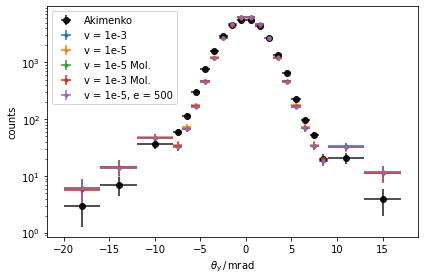

In [75]:
# akimenko data
plt.errorbar(bin_mids, AKIMENKO.counts, fmt='o', color='black', alpha=0.9, yerr=np.sqrt(AKIMENKO.counts), xerr=AKIMENKO.angle_low-bin_mids, label='Akimenko')

# run 03
plt.errorbar(bin_mids, hist_data_n_mean_03, fmt='.', yerr=hist_data_n_std_03, xerr=AKIMENKO.angle_low-bin_mids, label='v = 1e-3')
# plt.errorbar(bin_mids, hist_data_n_median_03, fmt='.', 
#              yerr=[hist_data_n_median_03-np.quantile(hist_data_n_03, 0.159, axis=0), np.quantile(hist_data_n_03, 0.841, axis=0)-hist_data_n_median_03],
#              xerr=AKIMENKO.angle_low-bin_mids,
#             label='median+68%')

# run 01
plt.errorbar(bin_mids, hist_data_n_mean_01, fmt='.', yerr=hist_data_n_std_01, xerr=AKIMENKO.angle_low-bin_mids, label='v = 1e-5')
# plt.errorbar(bin_mids, hist_data_n_median_01, fmt='.', 
#              yerr=[hist_data_n_median_01-np.quantile(hist_data_n_01, 0.159, axis=0), np.quantile(hist_data_n_01, 0.841, axis=0)-hist_data_n_median_01],
#              xerr=AKIMENKO.angle_low-bin_mids,
#             label='median+68%')

# run 04
plt.errorbar(bin_mids, hist_data_n_mean_04, fmt='.', yerr=hist_data_n_std_04, xerr=AKIMENKO.angle_low-bin_mids, label='v = 1e-5 Mol.')
# plt.errorbar(bin_mids, hist_data_n_median_04, fmt='.', 
#              yerr=[hist_data_n_median_04-np.quantile(hist_data_n_04, 0.159, axis=0), np.quantile(hist_data_n_04, 0.841, axis=0)-hist_data_n_median_04],
#              xerr=AKIMENKO.angle_low-bin_mids,
#             label='median+68%')

# run 02
plt.errorbar(bin_mids, hist_data_n_mean_02, fmt='.', yerr=hist_data_n_std_02, xerr=AKIMENKO.angle_low-bin_mids, label='v = 1e-3 Mol.')
# plt.errorbar(bin_mids, hist_data_n_median_02, fmt='.', 
#              yerr=[hist_data_n_median_02-np.quantile(hist_data_n_02, 0.159, axis=0), np.quantile(hist_data_n_02, 0.841, axis=0)-hist_data_n_median_02],
#              xerr=AKIMENKO.angle_low-bin_mids,
#             label='median+68%')

# run 05
plt.errorbar(bin_mids, hist_data_n_mean_05, fmt='.', yerr=hist_data_n_std_05, xerr=AKIMENKO.angle_low-bin_mids, label='v = 1e-5, e = 500')
# plt.errorbar(bin_mids, hist_data_n_median_05, fmt='.', 
#              yerr=[hist_data_n_median_05-np.quantile(hist_data_n_05, 0.159, axis=0), np.quantile(hist_data_n_05, 0.841, axis=0)-hist_data_n_median_05],
#              xerr=AKIMENKO.angle_low-bin_mids,
#             label='median+68%')


plt.yscale('log')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$mrad')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'akimenko_comparison_moliere_E7301MeV_final_multi_mean.pdf', bbox_inches='tight')